In [50]:
from datetime import date
today = date.today()

In [51]:
#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '1993-01-01'
date_end = today.strftime("%Y-%m-%d")

In [52]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [53]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], 
                       start=date_start, 
                       end=date_end, 
                       data_source='yahoo')
    name = stock[i]
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
        
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [54]:
combined_data

,SPY
Date,
1993-01-29,25.968958
1993-02-01,26.153660
1993-02-02,26.209057
1993-02-03,26.486113
1993-02-04,26.596937
...,...
2021-02-24,391.769989
2021-02-25,382.329987
2021-02-26,380.359985


<AxesSubplot:xlabel='Date'>

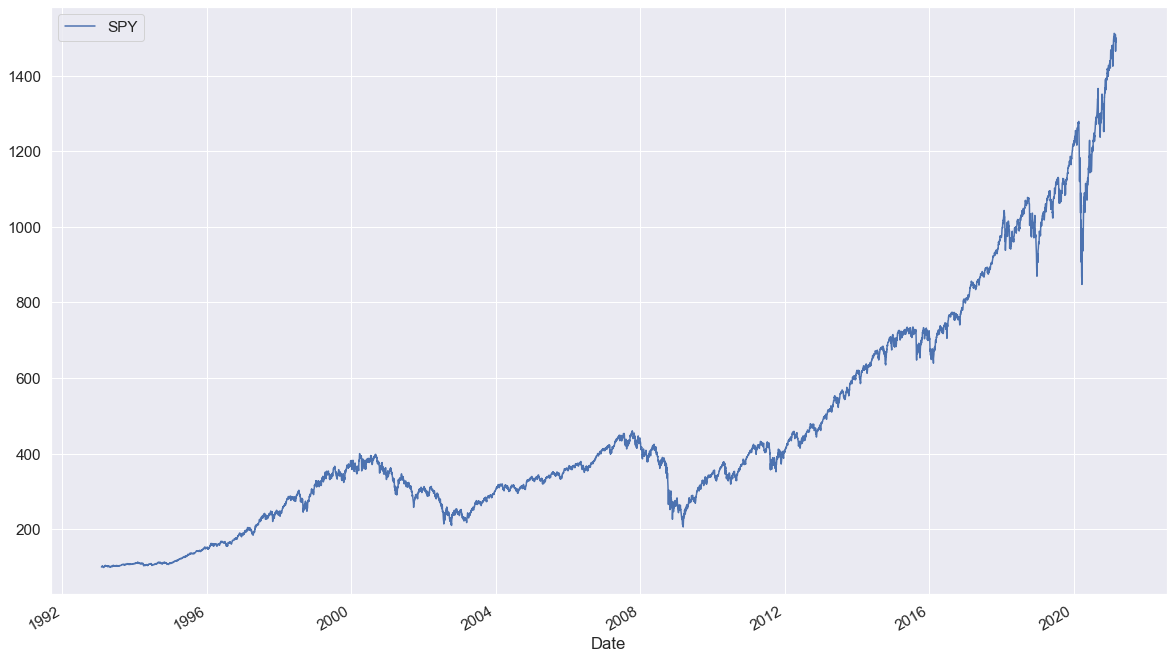

In [55]:
(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [56]:
combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data.dropna(inplace=True)
combined_data.head()

,SPY,return,direction
Date,,,
1993-02-01,26.153660,0.007087,1
1993-02-02,26.209057,0.002116,1
1993-02-03,26.486113,0.010516,1
1993-02-04,26.596937,0.004176,1
1993-02-05,26.578478,-0.000694,0


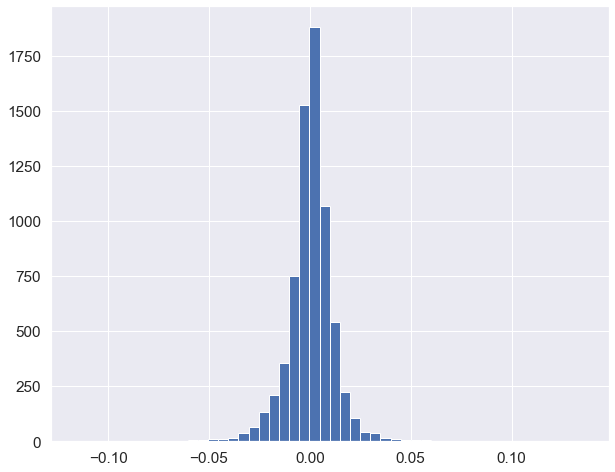

In [57]:
combined_data['return'].hist(bins=50, figsize=(10, 8));

# Feature Engineering

In [58]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

In [59]:
import ta
from ta.volatility import BollingerBands

In [60]:
indicator_bb = BollingerBands(close=combined_data['SPY'], window=20, window_dev=2)
combined_data['bb_bbm'] = indicator_bb.bollinger_mavg()
combined_data['bb_bbh'] = indicator_bb.bollinger_hband()
combined_data['bb_bbl'] = indicator_bb.bollinger_lband()

In [61]:
from ta.trend import MACD

In [62]:
indicator_macd = MACD(close = combined_data['SPY'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
combined_data['macd'] = indicator_macd.macd()
combined_data['macd_diff'] = indicator_macd.macd_diff()
combined_data['macd_signal'] = indicator_macd.macd_signal()

In [15]:
#from ta.momentum import StochRSIIndicator

In [17]:
#indicator_stoch = StochRSIIndicator(close = combined_data['SPY'], window = 14, smooth1 = 3, smooth2 = 3, fillna= False)
#combined_data['stochrsi'] = indicator_stoch.stochrsi()
#combined_data['stochrsi_d'] = indicator_stoch.stochrsi_d()
#combined_data['stochrsi_k'] = indicator_stoch.stochrsi_k()

In [63]:
combined_data['momentum'] = combined_data['return'].rolling(5).mean().shift(1)
combined_data['volatility'] = combined_data['return'].rolling(20).std().shift(1)
combined_data['distance'] = (combined_data[stock] - combined_data[stock].rolling(50).mean()).shift(1)

In [64]:
combined_data.dropna(inplace=True)
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-21,26.425627,-0.000703,0,-0.004900,-0.004181,0.000000,0.000000,-0.001390,26.579659,26.994298,26.165021,-0.014692,-0.012912,-0.001780,-0.002094,0.006664,-0.044106
1993-04-22,26.091602,-0.012721,0,-0.000703,-0.004900,-0.004181,0.000000,0.000000,26.551824,27.016068,26.087579,-0.050116,-0.038669,-0.011447,-0.001957,0.006641,-0.059621
1993-04-23,25.980268,-0.004276,0,-0.012721,-0.000703,-0.004900,-0.004181,0.000000,26.510070,27.019968,26.000172,-0.086180,-0.059786,-0.026394,-0.004501,0.007186,-0.387602
1993-04-26,25.776127,-0.007889,0,-0.004276,-0.012721,-0.000703,-0.004900,-0.004181,26.465533,27.061250,25.869816,-0.129738,-0.082675,-0.047063,-0.005356,0.007006,-0.489927
1993-04-27,26.054495,0.010742,1,-0.007889,-0.004276,-0.012721,-0.000703,-0.004900,26.429346,27.032567,25.826125,-0.140180,-0.074494,-0.065686,-0.006098,0.007095,-0.678391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,386.078500,399.272681,372.884319,3.510671,-0.434931,3.945602,-0.002462,0.009920,9.025182
2021-02-25,382.329987,-0.024391,0,0.010959,0.001214,-0.007721,-0.001768,-0.004265,386.474500,398.682639,374.266360,2.722356,-0.978597,3.700953,-0.000316,0.010181,12.763240
2021-02-26,380.359985,-0.005166,0,-0.024391,0.010959,0.001214,-0.007721,-0.001768,386.610999,398.476772,374.745225,1.916554,-1.427519,3.344073,-0.004341,0.010134,2.971542


<AxesSubplot:xlabel='Date'>

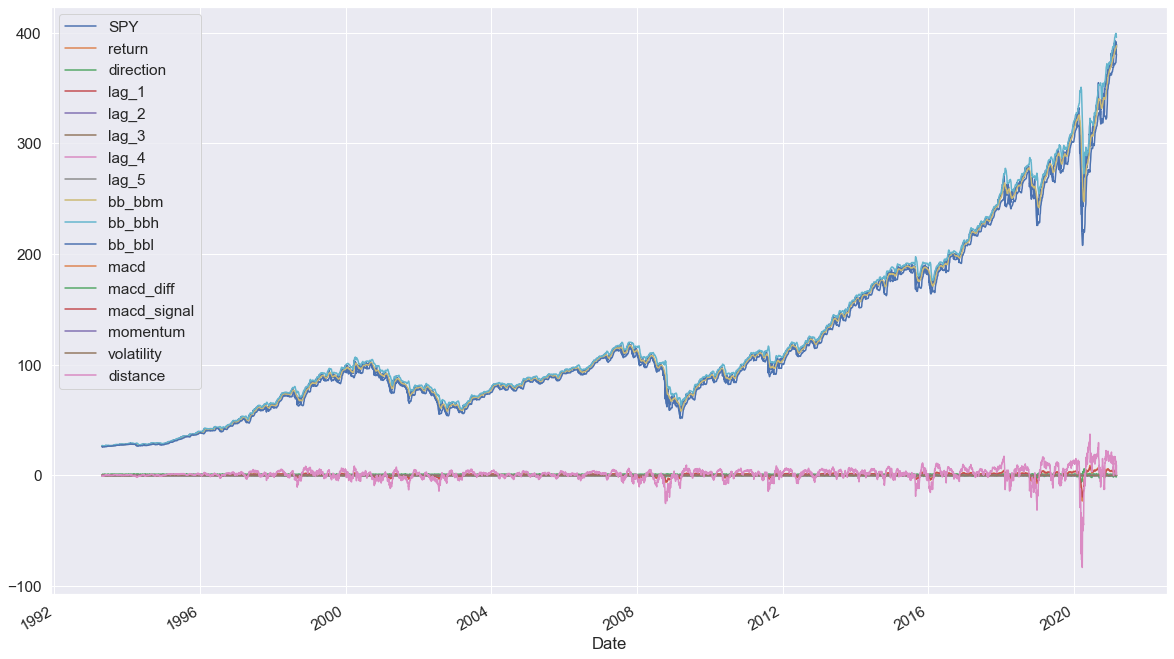

In [65]:
combined_data.plot(figsize=(20, 12))

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [67]:
cols = list(combined_data.columns)

In [68]:
cols = cols[3:]
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'macd',
 'macd_diff',
 'macd_signal',
 'momentum',
 'volatility',
 'distance']

In [69]:
X = combined_data[cols]

In [70]:
y = combined_data['direction']

In [71]:
split = int(0.7*len(combined_data))

In [72]:
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [73]:
import lightgbm as lgb
params = {'learning_rate': 0.01, 
          'max_depth': 12, 
          'boosting': 'gbdt',
          'num_leaves': 12,
          'objective': 'binary', 
          'metric': 'auc', 
          'seed': 33}


model = lgb.train(params, train_set=lgb.Dataset(X_train, label=y_train), num_boost_round=5000,
                  valid_sets=[lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_test, label=y_test)],
                  verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Info] Number of positive: 2620, number of negative: 2291
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 4911, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533496 -> initscore=0.134186
[LightGBM] [Info] Start training from score 0.134186
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.686619	valid_1's auc: 0.614221
[200]	valid_0's auc: 0.719297	valid_1's auc: 0.622703
[300]	valid_0's auc: 0.746464	valid_1's auc: 0.623966
[400]	valid_0's auc: 0.769818	valid_1's auc: 0.627167
[500]	valid_0's auc: 0.790219	valid_1's auc: 0.628411
[600]	valid_0's auc: 0.807478	valid_1's auc: 0.628961
[700]	valid_0's auc: 0.822319	valid_1's auc: 0.63035
[800]

In [74]:
import plotly.graph_objs as go
import plotly.offline as py

In [75]:
impo_df = pd.DataFrame({'imp': model.feature_importance(), 'col':cols})
impo_df = impo_df.sort_values(['imp','col'], ascending=[True, False])
colors=[]
for i in range(len(cols)):   
   if i % 2 == 0:
    colors.append('#EFC62E')
   else:
    colors.append('#EF7D2E')
data=[]
trace = go.Bar(
            orientation = 'h',
            x = impo_df.imp,
            y = impo_df.col,
            marker=dict(
              color= colors,
            )
        )
data.append(trace)
layout = go.Layout(
                title = "Feature Importance Chart",
                titlefont=dict(size=25),
                xaxis=dict(
                  title='Importance',   
                  titlefont=dict(size=20),
                ),
                yaxis=dict(
                  title="Feature",
                  tickangle=45,
                  automargin=True,
                  titlefont=dict(size=20),
                )               
             )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [76]:
combined_data['Predicted_Signal'] = model.predict(X)
combined_data['Original_SP_returns'] = combined_data['return']
Cumulative_originalSP500_returns = np.cumsum(combined_data[split:]['Original_SP_returns']).apply(np.exp)
combined_data['Strategy_Returns'] = combined_data['Original_SP_returns']* combined_data['Predicted_Signal']
Cumulative_Strategy_returns = np.cumsum(combined_data[split:]['Strategy_Returns']).apply(np.exp)

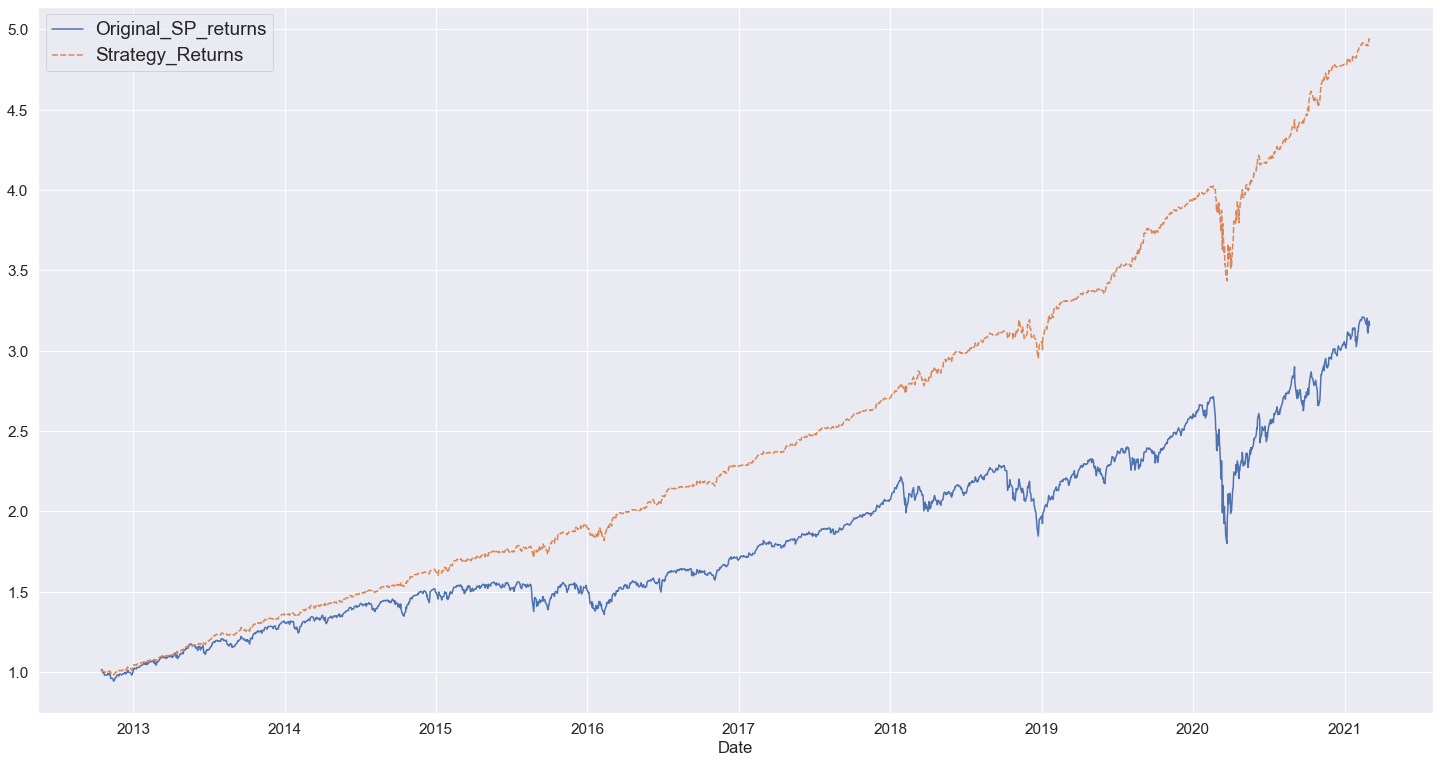

In [77]:
newdf = pd.concat([Cumulative_originalSP500_returns, Cumulative_Strategy_returns], axis=1)
 
 
#Graph plotting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
 
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)

# Grid Search

In [78]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [79]:
param_grid = [
    {'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2,4, 6, 10],
    'boosting': ['gbdt'],
    'num_leaves': [6,8,16, 32],
    'objective' : ['binary'],
    'seed': [33],
    'metric': ['auc' ],
    'n_estimators': [50, 100] 
    }
]

In [80]:
clf = LGBMClassifier()

In [81]:
gsearch = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, verbose = 3)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.540, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.576, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.559, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.538, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33, score=0.592, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33, score=0.567, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=2, metric=auc, n_estimators=100, num_leaves=16, objective=binary, see

[CV]  boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=50, num_leaves=32, objective=binary, seed=33, score=0.552, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=50, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=50, num_leaves=32, objective=binary, seed=33, score=0.601, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=50, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=50, num_leaves=32, objective=binary, seed=33, score=0.566, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=50

[CV]  boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33, score=0.540, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=4, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33, score=0.571, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.540, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=5

[CV]  boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.598, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.572, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.543, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=6, metric=auc, n_estimators=10

[CV]  boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.540, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.592, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.569, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=5

[CV]  boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.573, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.548, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.562, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.01, max_depth=10, metric=auc, n_estimat

[CV] boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33, score=0.578, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33, score=0.548, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


[CV] boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33, score=0.584, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33, score=0.543, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=

[CV] boosting=gbdt, learning_rate=0.05, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.577, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.622, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


[CV]  boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.597, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.555, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.567, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=50, num

[CV]  boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.578, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.586, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.599, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=6, metric=auc, n_estimators=10

[CV]  boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.571, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.612, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.588, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=5

[CV]  boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.593, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.582, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.550, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.05, max_depth=10, metric=auc, n_estimat

[CV]  boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33, score=0.541, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33, score=0.573, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=50, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=50, num_leaves=32, objective=binary, seed=33, score=0.562, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=50, num_

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33, score=0.578, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33, score=0.605, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=2, metric=auc, n_estimators=100, num_leaves=32, objective=binary, seed=33,

[CV]  boosting=gbdt, learning_rate=0.1, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.600, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.607, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=4, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.589, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=4, metric=auc, n_estimators=100, num

[CV]  boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.595, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.556, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=50, num_leaves=6, objective=binary, seed=33, score=0.572, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=50, num_leave

[CV]  boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=100, num_leaves=6, objective=binary, seed=33, score=0.565, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.576, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=100, num_leaves=8, objective=binary, seed=33, score=0.605, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=6, metric=auc, n_estimators=100, num

[CV]  boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=50, num_leaves=8, objective=binary, seed=33, score=0.580, total=   0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33, score=0.580, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=50, num_leaves=16, objective=binary, seed=33, score=0.599, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=50,

[CV]  boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33, score=0.587, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33, score=0.586, total=   0.2s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimators=100, num_leaves=16, objective=binary, seed=33, score=0.557, total=   0.1s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=10, metric=auc, n_estimato

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   26.5s finished


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid=[{'boosting': ['gbdt'],
                          'learning_rate': [0.01, 0.05, 0.1],
                          'max_depth': [2, 4, 6, 10], 'metric': ['auc'],
                          'n_estimators': [50, 100],
                          'num_leaves': [6, 8, 16, 32], 'objective': ['binary'],
                          'seed': [33]}],
             verbose=3)

In [82]:
gsearch.best_params_

{'boosting': 'gbdt',
 'learning_rate': 0.05,
 'max_depth': 4,
 'metric': 'auc',
 'n_estimators': 100,
 'num_leaves': 8,
 'objective': 'binary',
 'seed': 33}

In [84]:
clf_opt = LGBMClassifier(boosting='gbdt',
 learning_rate= 0.05,
 max_depth= 4,
 metric='auc',
 num_leaves= 8,
 objective= 'binary',
 seed= 33)

In [85]:
model = clf_opt.fit(X_train, y_train)

In [86]:
from sklearn.metrics import accuracy_score

In [87]:
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  58.07217473884141


In [88]:
cross_val = cross_val_score(model, X, y, scoring='accuracy', cv=10)
cross_val
cross_val.mean()

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boostin

0.5721868636989892

In [89]:
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.52      0.64      0.57       931
           1       0.65      0.54      0.59      1175

    accuracy                           0.58      2106
   macro avg       0.59      0.59      0.58      2106
weighted avg       0.59      0.58      0.58      2106



In [91]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

           0       0.52      0.64      0.57       931
           1       0.65      0.54      0.59      1175

    accuracy                           0.58      2106
   macro avg       0.59      0.59      0.58      2106
weighted avg       0.59      0.58      0.58      2106

Confusion Matrix
[[594 337]
 [546 629]]

Accuracy
0.5807217473884141


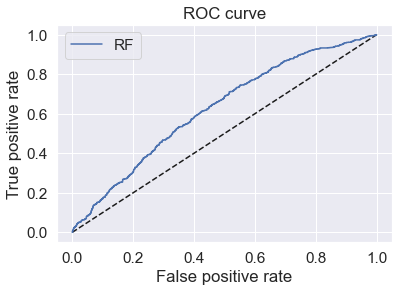

In [92]:
# Performance Metrics
y_pred_rf = clf_opt.predict_proba(X_test)[:, 1]
y_pred = clf_opt.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [93]:
combined_data['Predicted_Signal'] = model.predict(X)
combined_data['Original_SP_returns'] = combined_data['return']
Cumulative_originalSP500_returns = np.cumsum(combined_data[split:]['Original_SP_returns']).apply(np.exp)
combined_data['Strategy_Returns'] = combined_data['Original_SP_returns']* combined_data['Predicted_Signal']
Cumulative_Strategy_returns = np.cumsum(combined_data[split:]['Strategy_Returns']).apply(np.exp)

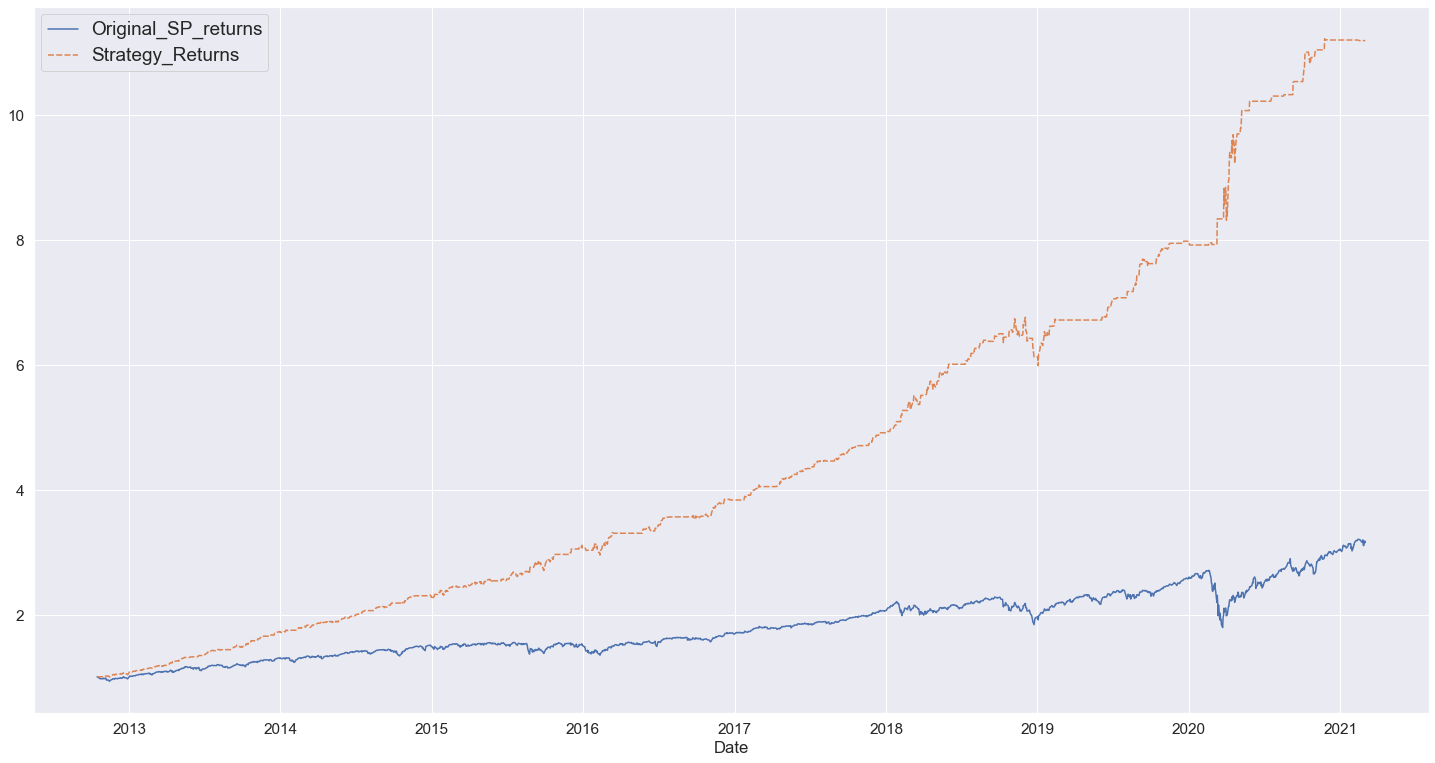

In [94]:
newdf = pd.concat([Cumulative_originalSP500_returns, Cumulative_Strategy_returns], axis=1)

 
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)

In [101]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

Start date,2013-01-02
End date,2021-03-02
Total months,97
,Backtest
Annual return,32.889%
Cumulative returns,916.314%
Annual volatility,9.153%
Sharpe ratio,3.15
Calmar ratio,2.83
Stability,0.99
Max drawdown,-11.607%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.61,2018-12-03,2019-01-03,2019-06-18,142
1,6.04,2020-03-30,2020-04-01,2020-04-06,6
2,5.66,2016-01-29,2016-02-11,2016-02-22,17
3,5.65,2015-09-16,2015-09-28,2015-10-08,17
4,4.81,2020-04-17,2020-04-21,2020-04-27,7


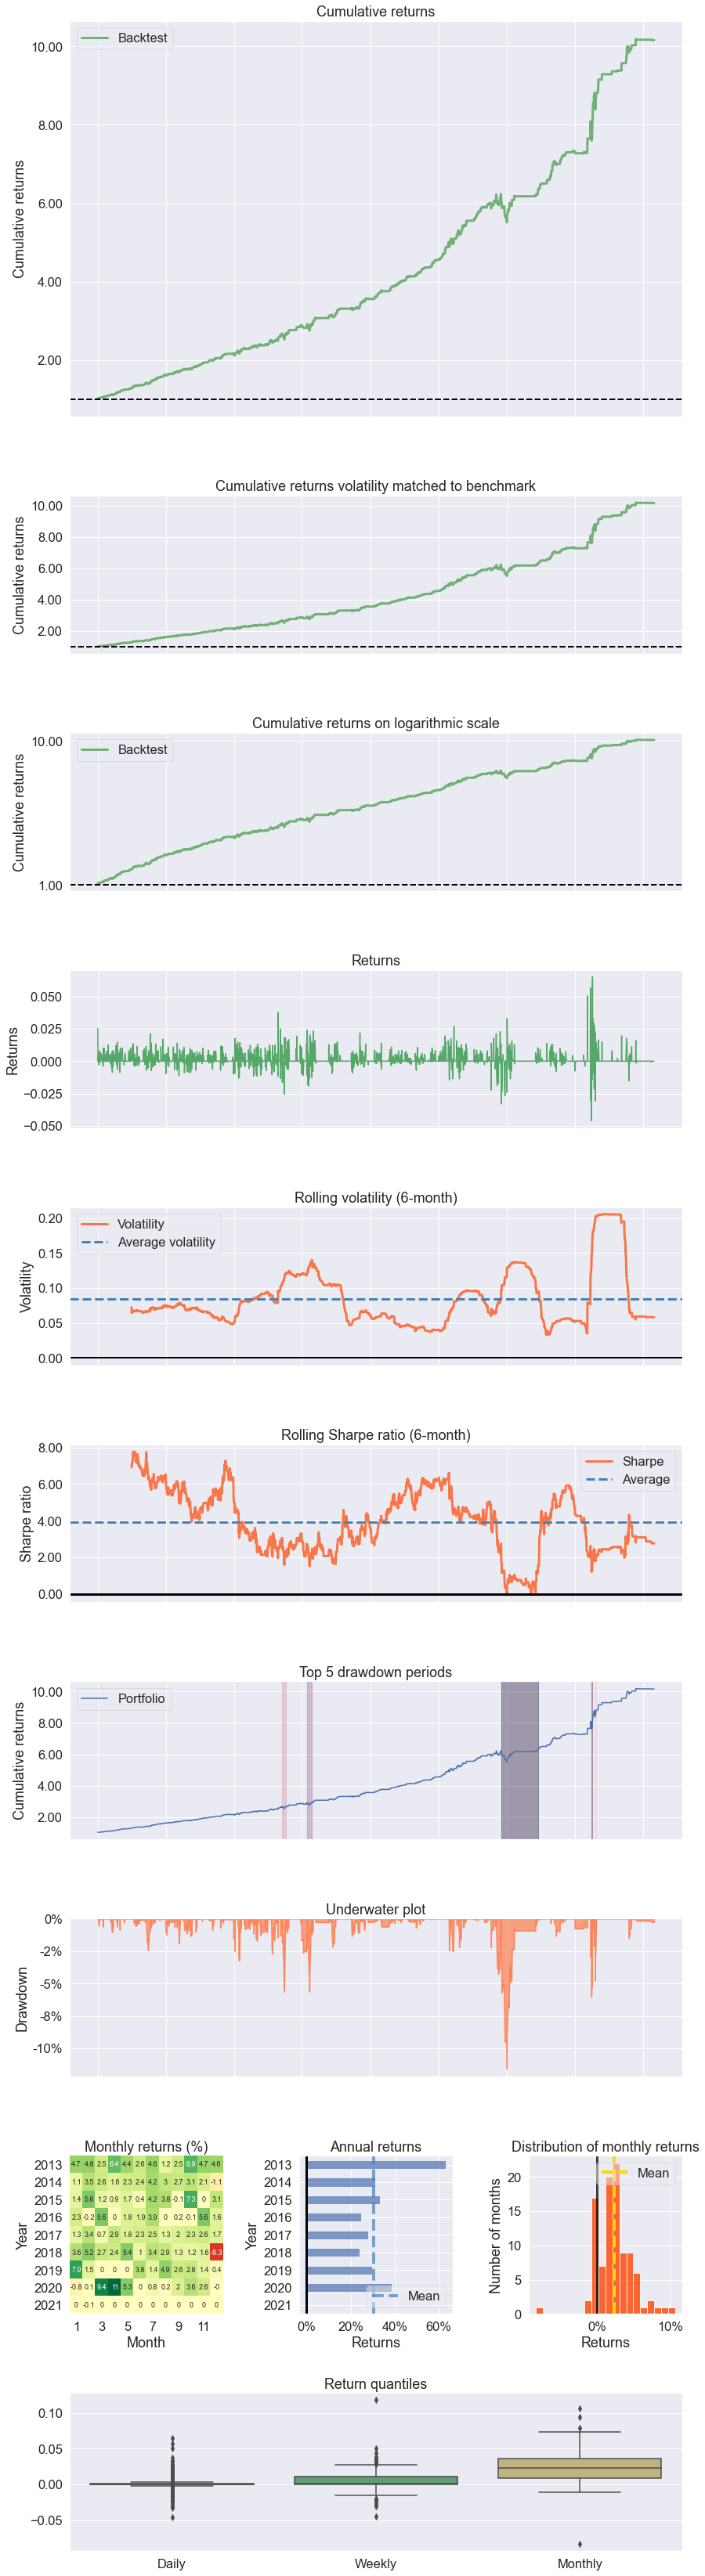

In [102]:
meta_returns = combined_data['Strategy_Returns'].loc['20130102':]
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)

In [97]:
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.metrics import auc


def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

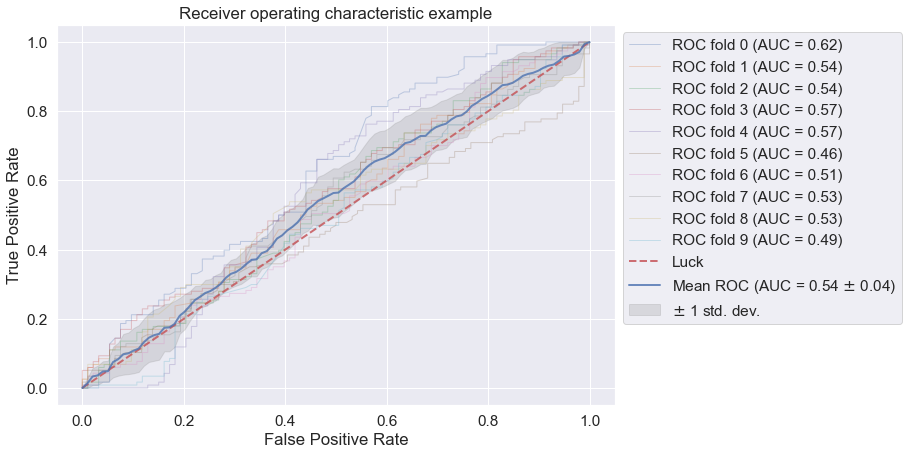

In [98]:
skf = StratifiedKFold(n_splits=10, shuffle=False)
classifier = RandomForestClassifier(n_estimators=10, max_depth=6, 
                                    criterion='entropy',
                                    class_weight='balanced_subsample',
                                    random_state=5)
crossValPlot(skf,classifier,X_test,y_test)

In [ ]:
#import shap

In [ ]:
#xgb feature importances
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(xgbfit)
shap_values = explainer.shap_values(pd.DataFrame(X_importance, columns = agg_market_df[fcol].columns))
shap.summary_plot(shap_values, X_importance, agg_market_df[fcol].columns)
shap.summary_plot(shap_values, X_importance, agg_market_df[fcol].columns, plot_type='bar')